# Klasyfikacja intro
  1. Wczytanie i obróbka zbiorów danych
  2. Uczenie i ewaluacja modelu
  3. ROC Analysis
  4. Klasyfikacja w Kearas

## Import bibliotek

In [ ]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
import seaborn as sns
from sklearn import tree
from sklearn.tree import  export_graphviz
from IPython.display import SVG, Image
!pip install graphviz
from graphviz import Source
from IPython.display import display
!apt-get -qq install -y graphviz


### Wycztywanie i obróbka zbioru danych
  1. Wczytaj zbór danych znajdujacy się tutaj: [vehicle_faults.csv](https://szymon.bobek.re/vehicle_faults.csv)
  2. Dokonaj nomalizacji numerycznych parametrów, zrób szybką anlizę
  3. Zakoduj label używając [LabelEncodera](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
  4. Zakoduj zmienne nienumeryczne za pomocą [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
  4. Podziel zbiór danych na zbiór ucząc i testowy w proporcjach 66% i 33% przy wykorzystaniu [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)


### Wczytanie zbioru uczącego

Wczytujemy zbiór danych historycznych o detekcji awarii w samochodach.
Opis kolumn:

    1. Number of previous faults
    2. Sensor 1 reading
    3. Sensor 2 reading
    4. Sensor 3 reading
    5. Sensor 4 reading
    6. Sensor 5 reading
    7. Sensor 6 reading
    8. Sensor 7 reading
    9. Vehicle Age (years)
    10. Vehicle Type (V1, V2, V3)
    11. Class variable (fault_risk, no_fault_risk)

In [ ]:
# Dla ułatwienia lista wszystkich cech, które będziemy wykorzystywać do uczenia
all_features = ['prev_faults','S1','S2','S3','S4','S5','S6','S7','age', 'vehicle_type']

target = 'class'
vehicle_data = pd.read_csv('https://szymon.bobek.re/vehicle_faults.csv')


In [ ]:
vehicle_data.head()

,prev_faults,S1,S2,S3,S4,S5,S6,S7,age,vehicle_type,class
0,6,14800,72,35,0,33.6,0.627,71.035,50,V1,fault_risk
1,1,8500,66,29,0,26.6,0.351,64.371,31,V3,no_fault_risk
2,8,18300,64,0,0,23.3,0.672,62.342,32,V3,fault_risk
3,1,8900,66,23,94,28.1,0.167,63.275,21,V3,no_fault_risk
4,0,13700,40,35,168,43.1,2.288,34.541,33,V2,fault_risk


### Normalizacja/Skalowanie cech
Przeskaluj cechy numeryczne (czyli wszystkie) używajac [StandarScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) z scikit.

In [ ]:
# Robimy scaling cech
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.exceptions import DataConversionWarning

cat_features = ['vehicle_type']
num_features = [f for f in all_features if f not in cat_features]

preprocessor = ColumnTransformer(remainder='passthrough',
        transformers=[
            ('cat', OneHotEncoder(categories='auto'),cat_features),
            ('num', StandardScaler(),num_features)])


df_scaled_array=preprocessor.fit_transform(vehicle_data)

cat_feat_names = list(preprocessor.named_transformers_['cat'].get_feature_names())

features_new = cat_feat_names + num_features

scaled_data= pd.DataFrame(df_scaled_array, columns=features_new+[target]).infer_objects()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Zakoduj klasę jako wartość numeryczną
Aktualnie kolumna klasy to wartośc nominalna przyjmująca jedną z dwóch wartości: `fault_risk` i `no_fault_risk`.
Chcemy przekonwertować tą zmienną do postaci numerycznej aby łatwiej było później nią manipulować (jeśli tego nie zorbimy, zostanie to zrobione automatycznie przez model)
Można to zrobić ręczenie, ale wygodniej jest użyc [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) stworzonego właśnei w tym celu.
Zapisz przekonwertowaną klasę w nowej koulmnie `encoded_class`

In [ ]:
scaled_data.head()

,x0_V1,x0_V2,x0_V3,prev_faults,S1,S2,S3,S4,S5,S6,S7,age,class
0,1.0,0.0,0.0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,0.107069,1.425995,fault_risk
1,0.0,0.0,1.0,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.234965,-0.190672,no_fault_risk
2,0.0,0.0,1.0,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.339105,-0.105584,fault_risk
3,0.0,0.0,1.0,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-0.291218,-1.041549,no_fault_risk
4,0.0,1.0,0.0,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-1.766012,-0.020496,fault_risk


In [ ]:
from sklearn import preprocessing
import seaborn as sns
le = preprocessing.LabelEncoder()
le.fit(scaled_data[target])
scaled_data['encoded_class'] = le.transform(scaled_data[target])
target='encoded_class'
scaled_data.head()

,x0_V1,x0_V2,x0_V3,prev_faults,S1,S2,S3,S4,S5,S6,S7,age,class,encoded_class
0,1.0,0.0,0.0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,0.107069,1.425995,fault_risk,0
1,0.0,0.0,1.0,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.234965,-0.190672,no_fault_risk,1
2,0.0,0.0,1.0,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.339105,-0.105584,fault_risk,0
3,0.0,0.0,1.0,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-0.291218,-1.041549,no_fault_risk,1
4,0.0,1.0,0.0,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-1.766012,-0.020496,fault_risk,0


### Przyjrzyjmy się danym
Dobrze jest zawsze przyjrzeć się danym nim zaczniemy uczenie.
Na wcześniejszychz zajęciach dużo mówiliśmy o erdukcji ilości cech (Lasso).
Czasem zdarza sie, ze w zbiorze mamy cechy silnie skorelowane, zdublowane.
Takich cech najlepiej się pozbyć.
Zobacz czy zbiór ten takie zawiera i usuń cechy przesadnie skorelowane.

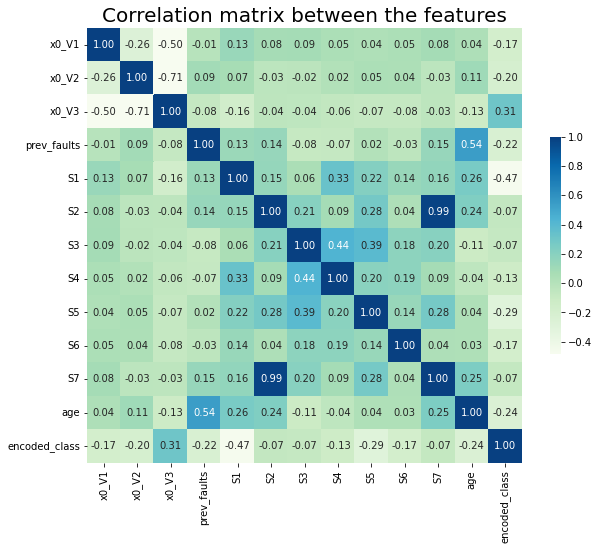

In [ ]:
correlation_matrix = scaled_data.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True,fmt='.2f', cmap ='GnBu', cbar_kws={"shrink": .5}, robust=True)
plt.title('Correlation matrix between the features', fontsize=20)
plt.show()

### Wyrysuj histogramy i boxploty dla kilku wybranych cech

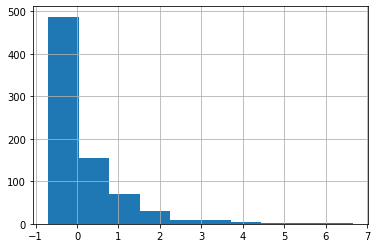

In [ ]:
scaled_data['S4'].hist()

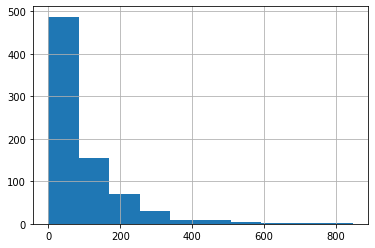

In [ ]:
vehicle_data['S4'].hist()

### Wyrysuj wyykres barplot pokazujacy rozkład klas i rozkład typu pojazdu

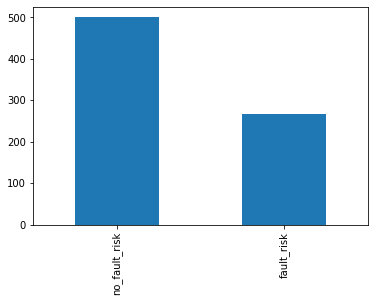

In [ ]:
scaled_data['class'].value_counts().plot(kind='bar')

### Podziel zbiór danych na treningowy i testowy
Podziel zbiór, tak aby w treningowym znalazło sie 67% danych, a w testowym 33%
Zapisz zbiory odpowiednio w zmiennych `train` i `test`

In [ ]:
scaled_data['class'] = scaled_data['class'].map({'fault_risk':1, 'no_fault_risk':0})
train, test = train_test_split(scaled_data, test_size=0.33, random_state=1)
all_features = [f for f in features_new if f not in ['S7']]


## Uczenie modelu
Wykorzystaj klasę [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) do nauczenia modelu.


### Naucz model wykorzystując `l1` penalty.
Żeby wykorzystać LASSO w regresji logitowej wystarczy przekazać odpowiedni parametr do obiektu:

``` python
# Parametr C, to 1/lambda ze slajdów
# Im mniejsze C tym większa kara
linear_model.LogisticRegression(C=0.01, penalty='l1')
```

**Uwaga** Zbiór danych jest niewielki. Dla dużych zbiorów danych wdzielilibysmy osobny zbiów walidacyjny na którym testowalibyśmy *jakość* paramtrów **C**. Jeśli mamy niewielki zbiór danych to możemy użyć *k_fold cross-validation* z [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html):

``` python
cv_result=cross_val_score(model, train[all_features], train[target],cv=10)
print('Mean accuracy: '+str(cv_result.mean()))
```

Przetestuj wartości parametru ze zbioru i wybierz najlepszy model

``` python
params = np.linspace(0,1,100)
```

Po nauczeniu modelu, zobacz które cechy zostały ustawione na zero i naucz model ponownie, ale tym raem z `l2` i powtórz operacje z  wyszukiwaniem odpowiedniego `C`.
Ucz model na wybranych w LASSO cechac:

``` python
idx = np.where(model.coef_.ravel()>  0)
new_features = [all_features[i] for i in idx[0]]
```

### Automatyczne szukanie C
Scikit learn pozwala na automatyzację procesu z poprzedniego kroku.
W tym celu można wykorzystać klasę [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

Np. aby przetestować wcześniejsze parametry `C` i wybrać najlepszy z użyciem *10-fold cross validaton*, wystarczy:

``` python
model = linear_model.LogisticRegressionCV(Cs=np.linspace(0,1,100), penalty='l1', cv=10, solver='liblinear')
```

Trochę szybciej...



In [ ]:
model = linear_model.LogisticRegression(C=0.7, penalty='l1')
model = linear_model.LogisticRegressionCV(Cs=np.linspace(0.001,1,100), penalty='l1', cv=10, solver='liblinear')
from sklearn import svm
#model = svm.LinearSVC()
#model = svm.SVC()


from sklearn.model_selection import cross_val_score
cv_result=cross_val_score(model, train[all_features], train[target],cv=10)
print(cv_result.mean())

model.fit(train[all_features], train[target])
preds = model.predict(test[all_features])
from sklearn.metrics import accuracy_score
accuracy_score(preds, test[target])

0.7452488687782806


0.8346456692913385

In [ ]:

idx = np.where(model.coef_.ravel()>  0)
ft = [all_features[i] for i in idx[0]]
model = linear_model.LogisticRegression(C=1, penalty='l2')
model.fit(train[ft], train[target])
preds = model.predict(test[ft])
from sklearn.metrics import accuracy_score
print(accuracy_score(preds, test[target]))
print(ft)


0.6811023622047244
['x0_V3', 'S2', 'S3', 'S4']


## Krzywa ROC
### Predykcja z wykorzystaniem sigmoidy
Jak widzisz metryk do ewaluacji jest wiele, accuracy, F1, precision, recall, ROC...
Krzywą tą można wyznaczyć licząc *true positive rate* i *false positive rate* dla różnych progów rozgraniczajacych klasy.
Elementy są klasyfickowane względem tego co zwraca nam funkcja sigmoidalna.
Np. Jeśli wartość sigmoidy dla danego elementu jest powyżej 0.5 to ustalamy, że element należy do klasy 1 w przeciwnym razie do klasy 0.

Dla przypomnienia wzór sigmoidy to:

$$g(z_x) = \frac{1}{1+e^{-z_x}}$$

Aby wyliczyć wartość tej sigmoidy musimy znać wartość parametru $z$, która z kolei jest wartością funkcji której parametrów szukaliśmy:
$$z_x = h_0(x) = g(\theta^Tx) $$

Zmodyfikuj finkcję poniżej tak aby pasowała do twoich zmiennych i uruchom ją:

``` python

gzx = np.dot(test_dataset[features], model.coef_.T) + model.intercept_

```

Wynik z `gzx` należy nastepnie wrzucić do sigmoidy aby otrzymać prawdopodobieństwo przynależnosci do klasy 1 dla danego elementu.
Zauważ, że domyślnie klasyfikujemy element jako należący do klasy 1, gdy wartość sigmoidy jest większa od 0.5. (żeby sprawdzić, czy prawdopodobieństwa zostały wyznaczone poprawnie, użyj funkcji [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) wbudowanej w model)
Zaimplementuj własną metodę predict zgodnie ze szkieletem poniżej.
Użyj parametru **threshold** do decydowania od jakiej wartości sigmoidy klasyfikować będziemy element jako należący do klasy 1.
Porównaj wtyniki funkcji poniżej i tej wbudowanej - powienieneś otrzymać te same wyniki.

``` python
def myPredict(model, test_set, features, threshold=0.5):
  //TODO your code
  return predict
  
```

In [ ]:
def myPredict(model, test_set, features, threshold=0.5):
    gzx = np.dot(test_set[features], model.coef_.T) + model.intercept_
    predict = [1 if 1/(1+np.exp(-z)) > threshold else 0 for z in gzx]
    return predict

### TPR i FPR i krzywa ROC
Mając juz funkcję zwracającą score predykcji, możemy modyfikować próg przy jakim prognozujemy klasę 1 lub 0 i wyznaczać *true positive rate* i *false positive rate* dla tych różnych progów.
Napisz funkcję zwracającą te dwie własności według sygnatury poniżej.
Wykorzystaj napisaną wcześniej funkcję do tego, żeby wyznaczyć tpr i fpr dla różnych wartości threshold.
Wykorzystaj wartościo threshold dane poniżej.

``` python
def get_tpr_fpr(model, test_set, features, target, threshold):
  //TODO Twój kod
  
  return tpr,fpr
```

Dla przypomnienia czym jest TPR i FPR:

$$TPR=\frac{\mathit{TruePositives}}{\mathit{Positives}}$$


$$FPR=\frac{\mathit{FalsePositives}}{\mathit{Negatives}}$$

In [ ]:
from sklearn.metrics import roc_curve, auc
def get_tpr_fpr(model, test_set, features, target, threshold):
    prediction = myPredict(model, test_set, features, threshold)
    pos = sum(test_set[target])
    neg = len(test_set) - pos

    tp = sum([1 if p == 1 and t == 1 else 0 for t,p in zip(test_set[target], prediction)])
    fp = sum([1 if p == 1 and t == 0 else 0 for t,p in zip(test_set[target], prediction)])

    return tp/pos,fp/neg


#### Narysuj krzywa ROC
Wykorzystując napisaną funkcję narysuj zależność tpr od fpr.
Będzie to krzywa ROC!
Możesz obliczyć pole pod krzywą, ale łatwiej użyc wbudowanej funkcji [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc).
Wyznaczyć fpr i tpr również możesz używając wbudowanej funkcji [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)

Do wyrysowania krzywej ykorzystaj co wolisz!

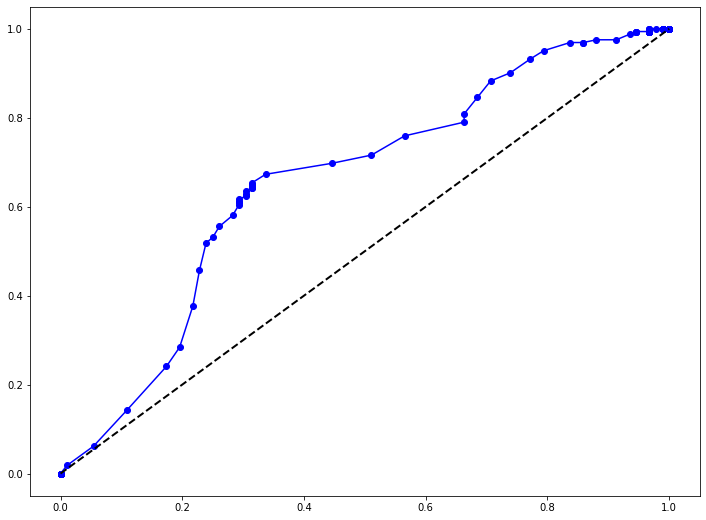

In [ ]:
from sklearn.metrics import classification_report

def find_tprs_fprs(model, test_set, features, targer, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        pred = myPredict(model, test_set, features, 0.5)
        tpr_t,fpr_t=get_tpr_fpr(model, test_set, features, target, threshold)
        tpr.append(tpr_t)
        fpr.append(fpr_t)

    return tpr,fpr


thresholds = np.linspace(1,0,100)
thresholds

tpr1, fpr1 = find_tprs_fprs(model, test, ft, target, thresholds)
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111,)
ax.grid(False)

ax.plot(fpr1, tpr1,'b-o')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_facecolor('xkcd:white')
plt.show()

### Aby porównać więcej modeli

['x0_V3', 'S2', 'S3', 'S4']
0.6732283464566929
0.7011876006441223
              precision    recall  f1-score   support

           0       0.61      0.27      0.38        92
           1       0.69      0.90      0.78       162

    accuracy                           0.67       254
   macro avg       0.65      0.59      0.58       254
weighted avg       0.66      0.67      0.63       254

0.6771653543307087
0.654891304347826
              precision    recall  f1-score   support

           0       0.65      0.24      0.35        92
           1       0.68      0.93      0.79       162

    accuracy                           0.68       254
   macro avg       0.66      0.58      0.57       254
weighted avg       0.67      0.68      0.63       254



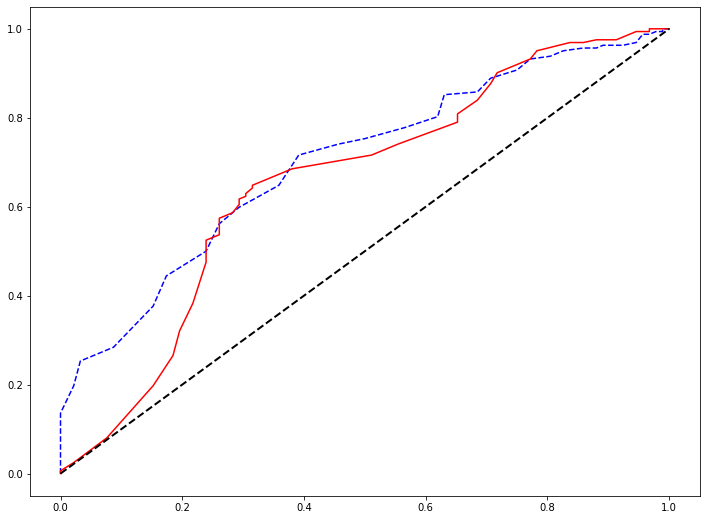

In [ ]:
from sklearn.metrics import classification_report

def find_tprs_fprs(model, test_set, features, targer, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        pred = myPredict(model, test_set, features, 0.5)
        tpr_t,fpr_t=get_tpr_fpr(model, test_set, features, target, threshold)
        tpr.append(tpr_t)
        fpr.append(fpr_t)

    return tpr,fpr



features = [all_features[i] for i in [7,8,9]]
print(ft)

model1 = linear_model.LogisticRegressionCV(Cs=np.linspace(0.001,1,100), penalty='l2', cv=10, solver='liblinear')
model1.fit(train[features], train[target])


model2 = linear_model.LogisticRegressionCV(Cs=np.linspace(0.001,1,100), penalty='l2', cv=10, solver='liblinear')
model2.fit(train[ft], train[target])


thresholds = np.linspace(1,0,100)
thresholds

tpr1, fpr1 = find_tprs_fprs(model1, test, features, target, thresholds)
tpr2, fpr2 = find_tprs_fprs(model2, test, ft, target, thresholds)

print(model1.score(test[features], test[target]))
print(auc(fpr1, tpr1))
print(classification_report(test[target], model1.predict(test[features])))

print(model2.score(test[ft], test[target]))
print(auc(fpr2, tpr2))
print(classification_report(test[target], model2.predict(test[ft])))

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111,)
ax.grid(False)

ax.plot(fpr1, tpr1,'b--')
ax.plot(fpr2, tpr2,'r')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_facecolor('xkcd:white')
plt.show()



### ROC dla oglnego przypadku
Rysowanie ROC dla przypadku trzy i więcej klasowego jest trochę bardziej skomplikowane, dlatego z pomocą przychodzi funkcja poniżej :)
Za jej pomoca wyrysuj ROC dla stworzonych wcześniej modeli.


In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

def plot_roc(model, datasetX, datasety, saveas=None):
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve,auc
    from sklearn.model_selection import train_test_split
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp

    n_classes = len(np.unique(datasety))

    if hasattr(model ,'decision_function'):
        y_score = model.decision_function(datasetX)
    else:
        if n_classes < 3:
            y_score = model.predict_proba(datasetX)[::,1]
        else:
            y_score = model.predict_proba(datasetX)
    y = label_binarize(datasety, classes=np.unique(datasety))


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 2:
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        else:
            fpr[i], tpr[i], _ = roc_curve(datasety, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(datasety, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    fig=plt.figure(figsize=(12,9))
    plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'gold', 'khaki', 'red', 'violet','purple'])
    for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC analysis')
    plt.legend(loc="lower right")
    plt.show()
    if saveas is not None:
        fig.savefig(saveas)

## Drzewa decyzyjne
Drzewa decyzyjne w Pythonie to tak naprawdę jeden algorytm: [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29).

Zalet drzew decyzyjnych jest kilka:
*  Nie wymagają normalizacji parametrów
*  Działają zarówno na danych symbolicznych, numerycznych imeiszanych, bez konieczności OneHotEncodingu czy LabelEncoderów
*  Potrafią bez zbędnych manipulacji an danych radzić sobie z brakującymi danymi
*  Są interpretowalne -- model jest zrozumiały i samotłumaczący się (w przeciwieństwie np do SVM np. z kernelem RBF)
*  Moga być sotsowane do wielu zadań: klasyfikacja, regresja, a nawet klasteryzacja

Wady:
*  Drzewa decyzyjne są czułe na perturbacje danych, jeśli parametry sa dobrane nieodpowiednio
*  [Granice decyzyjne](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html) sa zawsze rwnoległe do osi (co nie koniecznie jest dobre -- np. granica diagonalne nie jest możliwa ad hoc)

In [ ]:
vehicle_data = pd.read_csv("https://szymon.bobek.re/vehicle_faults.csv")
vehicle_data['vehicle_type'] = vehicle_data['vehicle_type'].map({'V1':0, 'V2':1, 'V3':2})
vehicle_data['class'] = vehicle_data['class'].map({'fault_risk':1, 'no_fault_risk':0})
train_o, test_o = train_test_split(vehicle_data, test_size=0.33,random_state=1)
features = ['prev_faults','S1','S2','S3','S4','S5','S6','S7','age', 'vehicle_type']
target_o = 'class'



vehicle_data.head()

,prev_faults,S1,S2,S3,S4,S5,S6,S7,age,vehicle_type,class
0,6,14800,72,35,0,33.6,0.627,71.035,50,0,1
1,1,8500,66,29,0,26.6,0.351,64.371,31,2,0
2,8,18300,64,0,0,23.3,0.672,62.342,32,2,1
3,1,8900,66,23,94,28.1,0.167,63.275,21,2,0
4,0,13700,40,35,168,43.1,2.288,34.541,33,1,1


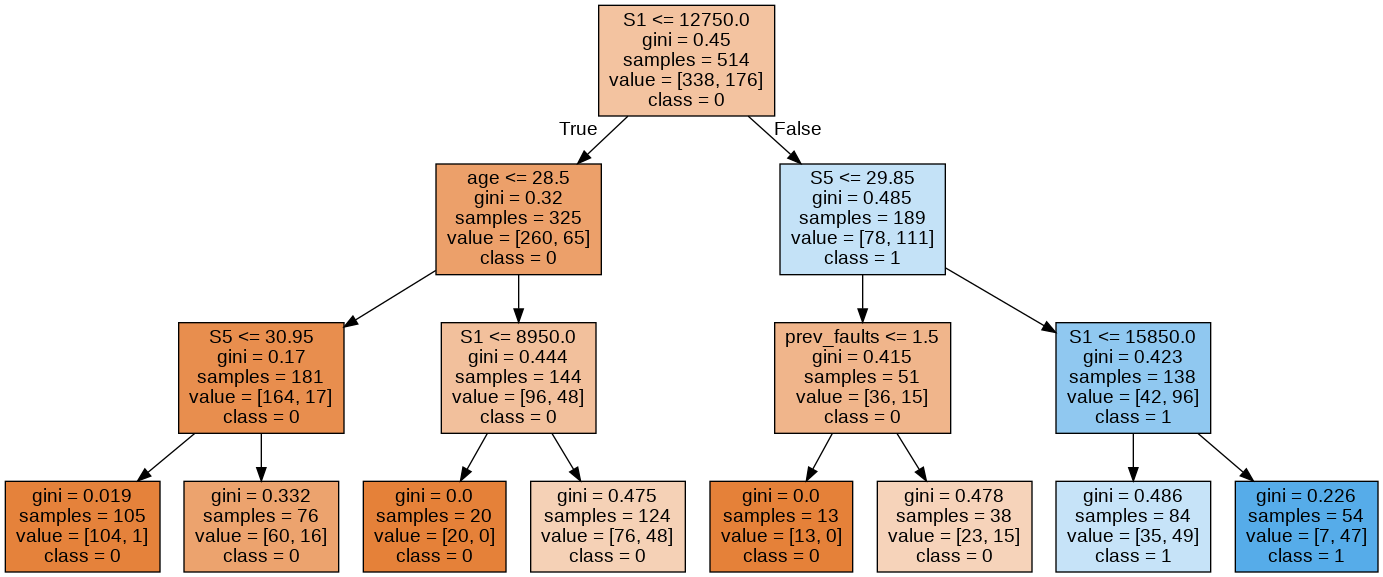

In [ ]:
estimator = tree.DecisionTreeClassifier(max_depth=3)
estimator.fit(train_o[features], train_o[target_o])


graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=features, class_names=['0', '1']
   , filled = True))


display(Image(graph.pipe(format='png')))

In [ ]:
estimator.score(test_o[features], test_o[target_o])

0.7874015748031497

In [ ]:
test_o[target_o]

285    0
101    0
581    0
352    0
726    0
      ..
491    0
49     0
31     1
601    0
510    1
Name: class, Length: 254, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


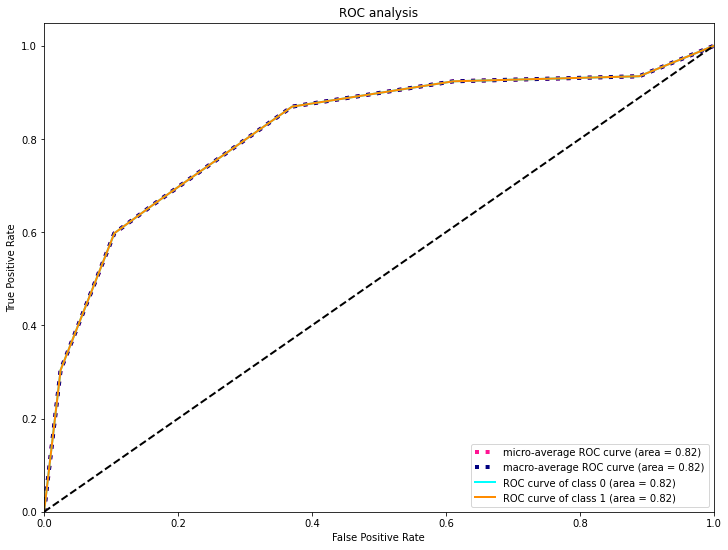

In [ ]:

from sklearn import metrics

plot_roc(estimator, test_o[features], test_o[target_o])

#y_pred_proba = estimator.predict_proba(test_o[features])[::,1]
##fpr, tpr, _ = metrics.roc_curve(test_o[target_o],  y_pred_proba, pos_label='no_fault_risk')
#auc_val = metrics.roc_auc_score(test_o[target_o], y_pred_proba)
#plt.figure(figsize=(12,9))
#plt.plot(fpr,tpr,label="Decision tree classification, auc="+str(auc_val))
#plt.legend(loc=4)
#plt.plot([0, 1], [0, 1], 'k--', lw=2)
#plt.show()

### Przeanalizuj wykresy dla różnych mdoeli
Wykorzystujac cały czas ten sam zbiór danych, wygeneruj dwa modele dla różnych parametrów `C` i różnych zbiorów cech.
Na przykład `model1` dla `C=0.9` i `features = ['age', 'S1', 'S2']` i `model2` dla `C=0.009` i `features = ['age', 'vehicle_type', 'S3', 'S4', 'S8']`.
Wyrysuj krzywe ROC, wypisz pola pod krzywymi, wyświetl następujace parametry (dostosuj oczywiście nazwy zmiennych, tak aby odpowiadały Twoim):

``` python
print(model1.score(test_set[features], test_set[target]))
print(auc(model1_fpr, model1_tpr))
print(classification_report(test_set[target], model.predict(test_set[features])))
```

Jak testowac więcej ustawień?

``` python
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(0.1,1,10)}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train[all_features],train[target])
```

Przetestuj następujące algorytmy:
  * [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  * [NaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
  * [MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
  * [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

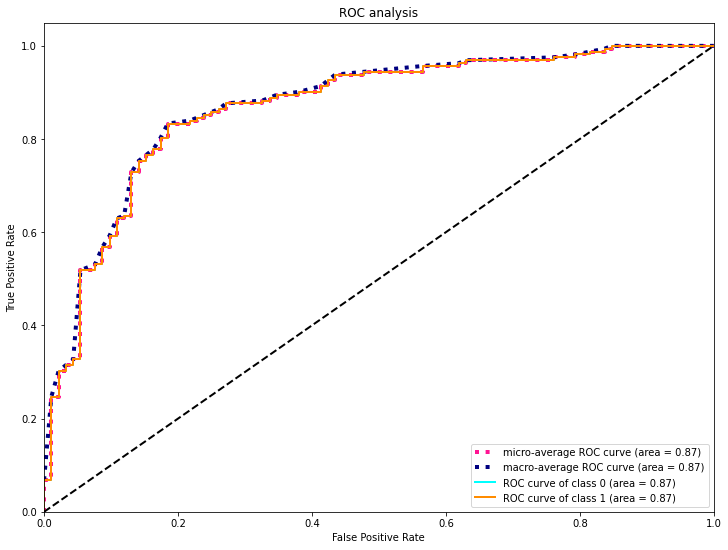

0.8031496062992126

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(0.1,1,10)}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train[all_features],train[target])

clf.best_estimator_

rdc = linear_model.LogisticRegression()
rdc = GaussianNB()
rdc=MLPClassifier(hidden_layer_sizes=(100,10))
rdc.fit(train[all_features],train[target])

#plot_roc(clf, test, all_features, target)
plot_roc(rdc, test[all_features], test[target])
rdc.score(test[all_features], test[target])


In [ ]:
vehicle_data = pd.read_csv("https://szymon.bobek.re/vehicle_faults.csv")
vehicle_data['class'] = vehicle_data['class'].map({'fault_risk':0, 'no_fault_risk':1})
train_gs, test_gs = train_test_split(vehicle_data, test_size=0.33,random_state=1)
features_gs = ['prev_faults','S1','S2','S3','S4','S5','S6','S7','age', 'vehicle_type']
target_gs = 'class'

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer,f1_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

scorer = make_scorer(f1_score, greater_is_better=True)


cat_features = ['vehicle_type']
num_features = [f for f in features_gs if f not in cat_features]


preprocessor = ColumnTransformer(remainder='passthrough',
        transformers=[
            ('cat', OneHotEncoder(categories='auto'),cat_features),
            ('num', StandardScaler(),num_features)])



steps = [('preprocessor',preprocessor),('classifier', DummyClassifier())]
pipeline = Pipeline(steps) # define the pipeline object


# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'preprocessor__num':[MinMaxScaler(),StandardScaler(), RobustScaler()]},
                {'classifier': [svm.SVC()],
                 'classifier__C': np.logspace(0, 4, 10)},

                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3,4,5,6,7,8]}]




#parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=search_space, cv=5,scoring=scorer)

grid.fit(train_gs[features_gs],train_gs[target_gs])

grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['vehicle_type']),
                                                 ('num', StandardScaler(),
                                                  ['prev_faults', 'S1', 'S2',
                                                   'S3', 'S4', 'S5', 'S6', 'S7',
                                                   'age'])])),
                ('classifier', RandomForestClassifier(max_features=6))])

## Keras
Jak klasyfikacja może wyglądać w Keras?
Przyjemnie :)

Zakładamy, ze dane mamy wczytane jak dotychczas w DataFrame odpowiednio `train` i `test`.
Cechy zapisane w listach `all_features` i `target`.

### Tworzymy model

In [ ]:
model = Sequential()
#Mamy len(all_features) wejść dla pierwszej warstwy 12 neuronów
model.add(Dense(12, input_dim=len(all_features), activation='relu'))
#8 neuronów w drugiej warstwie (troche na wyrost, ale niech będzie)
model.add(Dense(8, activation='relu'))
#problem binarny, więc jedno wyjście wystarczy
#w przypadku wieloklasowego tą warstę można zastąpić softmaxem z ilością neuronów odpowiadajacą ilości klas:
#model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))


### Kompilujemy model
Kkomiplacja to przekształcenie modelu do postaci wykorzystywanej przez TensorFlow.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Uczymy

In [ ]:
model.fit(train[all_features], train[target], epochs=150, batch_size=10)


Epoch 1/150
52/52 [==============================] - 1s 2ms/step - loss: 0.6516 - accuracy: 0.6342
Epoch 2/150
52/52 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.7062
Epoch 3/150
52/52 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.7140
Epoch 4/150
52/52 [==============================] - 0s 2ms/step - loss: 0.5244 - accuracy: 0.7160
Epoch 5/150
52/52 [==============================] - 0s 2ms/step - loss: 0.5087 - accuracy: 0.7218
Epoch 6/150
52/52 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.7276
Epoch 7/150
52/52 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7451
Epoch 8/150
52/52 [==============================] - 0s 2ms/step - loss: 0.4793 - accuracy: 0.7549
Epoch 9/150
52/52 [==============================] - 0s 2ms/step - loss: 0.4726 - accuracy: 0.7646
Epoch 10/150
52/52 [==============================] - 0s 2ms/step - loss: 0.4671 - accuracy: 0.7685
Epoch 11/

### Ewaluacja

In [ ]:
scores = model.evaluate(test[all_features], test[target])
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

proba = model.predict(test[all_features])
proba[:10]


8/8 [==============================] - 0s 7ms/step - loss: 0.4702 - accuracy: 0.7835

accuracy: 78.35%


array([[0.18508333],
       [0.24505594],
       [0.91274965],
       [0.8769567 ],
       [0.92603725],
       [0.86983895],
       [0.63903046],
       [0.98855686],
       [0.30209643],
       [0.9236517 ]], dtype=float32)

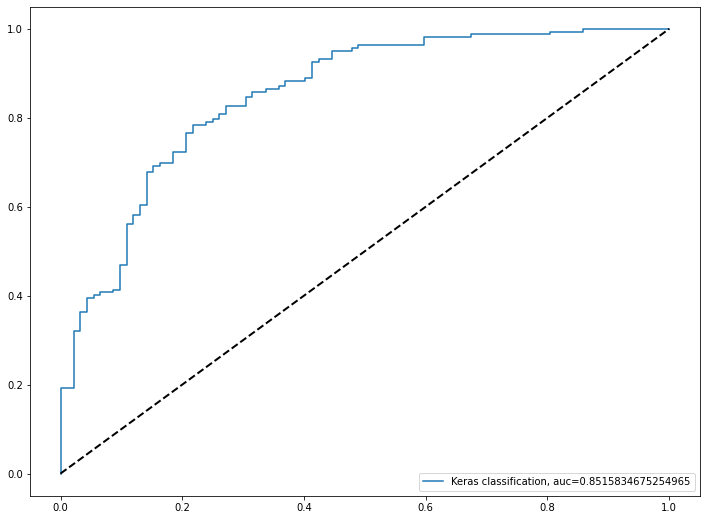

In [ ]:
from sklearn import metrics

y_pred_proba = model.predict(test[all_features])[::,0]
fpr, tpr, _ = metrics.roc_curve(test[target],  y_pred_proba)
auc_val = metrics.roc_auc_score(test[target], y_pred_proba)
plt.figure(figsize=(12,9))
plt.plot(fpr,tpr,label="Keras classification, auc="+str(auc_val))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.show()

## Klasyfikacja wieloklasowa

W przypadku klasyfikacji wieloklasowej przy zastosowaniu [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) możemy użyć jednego z parametrów modelu (`multi_class`) do ustalenia strategii uczenia i predykcji. Możliwe wartośći to:
*   `ovr`, czyli One Versus Rest
*   `multinomial`, czyli (proawdopodobnie) softmax
  
Innym podejściem jest użycie wrappera, pozawalającego na opakowanie dowolnego modelu strategiami:
*    [OneVsOneClassifier](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-one), czyli implementacja one versus one
*    [OneVsRestClassifier](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest), czyli implementacja one versus all

Jeszcze innym jest po prostu wykorzystanie drzew decyzyjnych



## Drzewa decyzyjne w klasyfikacji wieloklasowej

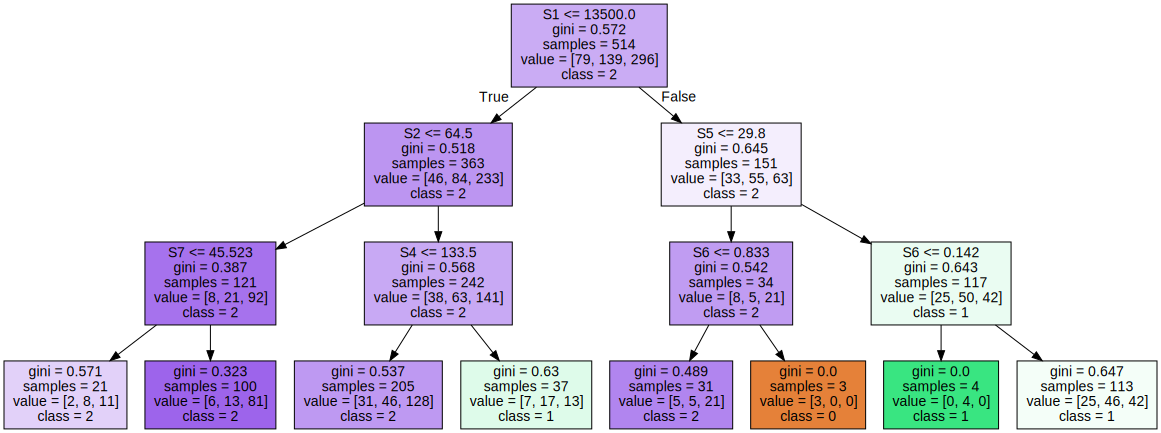

In [ ]:
vehicle_data = pd.read_csv("https://szymon.bobek.re/vehicle_faults.csv")
vehicle_data['vehicle_type'] = vehicle_data['vehicle_type'].map({'V1':0, 'V2':1, 'V3':2})
vehicle_data['class'] = vehicle_data['class'].map({'fault_risk':0, 'no_fault_risk':1})
train_o, test_o = train_test_split(vehicle_data, test_size=0.33,random_state=42)
features = ['prev_faults','S1','S2','S3','S4','S5','S6','S7','age']
target_o = 'vehicle_type'

estimator = tree.DecisionTreeClassifier(max_depth=3)
estimator.fit(train_o[features], train_o[target_o])


graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=features, class_names=['0', '1','2']
   , filled = True))


display(SVG(graph.pipe(format='svg')))

### OVR i OVO
Porównaj działanie wrapperów OneVsOneClassifier  i OneVsRestClassifier dla zbioru.
(aby wyrysować krzywą ROC patrz końcówka zajęć)

0.5708661417322834


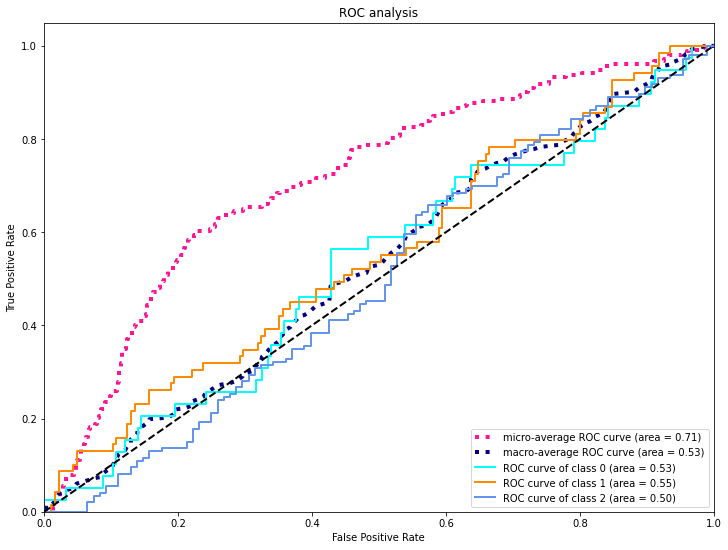

In [ ]:
import warnings
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
warnings.filterwarnings('ignore')


modela=linear_model.LogisticRegression()

ovr = OneVsRestClassifier(modela).fit(train_o[features], train_o[target_o])
ovo = OneVsOneClassifier(modela).fit(train_o[features], train_o[target_o])

score = ovr.score(test_o[features], test_o[target_o])
print(score)

plot_roc(ovo, test_o[features], test_o[target_o])

# Do samodzielnego wykonania
Wykonaj klasyfikcję dla zbioru danych `flight_sample.zip`
Opis kolumn i zbioru danych: [United States Department of Transportation](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time).


Wykonaj następujące kroki:

**Uwaga** Zbiór danych nie ma wysnacoznych klas. Opóźnienei jest liczbą ciągłą.
Zdecyduj co wolisz robić:
  * Wykonać regresję i przewidywać konkretną wartośc opóźnienia
  * Wykonać klasyfikację ( w tym przypadku musisz podzielić jakoś ciągła wartość na wartości dyskretne). Można to zrobić za pomocą [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer), albo fukcji poniżej:


``` python
def make_class(value):
    if value <= 0:
        return 0 # erlier
    elif value <= 15:
        return 1 # acceptable delay
    elif value <= 30:
        return 2 # serious delay
    else:
        return 1 # not acceptable delay

flights['class'] = flights['ARRIVAL_DELAY'].apply(make_class)
```


## Wykonaj nastepujące kroki
  * Używaj gdzie się da `random_state=42`
  * Zrób analizę zbioru danych i zobacz z jakimi danymi pracujesz.
    * Czy jakichś danych brakuje?
    * Zrób wykresy rozkładu dla cech numerycznych i bar ploty dla cech symbolicznych.
    * Wyrysuj boxplot i hist dla ARRIVAL_DELAY (przed ewentualną dyskretyzacją) -- czy warto usuną wartości odstające?
  * Wybierz cechy do uczenia i wykonaj odpowiedni preprocessing
    * Zakoduj zmienne nienumeryczne używając OHE (czy wystarczy pamięcia na wszystkie?)
    * Użyj StandardScalera do znormalizowania danych numerycznych
    * Podziel zbiór danych na treningowy i testowy
  * Naucz model (wyrysuj ROC dla klasyfikacji) i wybierz najlepszy (np. używając GridSearchCV)
